#Import library

In [75]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from tqdm import tqdm
import warnings
import time
import math
warnings.filterwarnings('ignore')


#Open Image

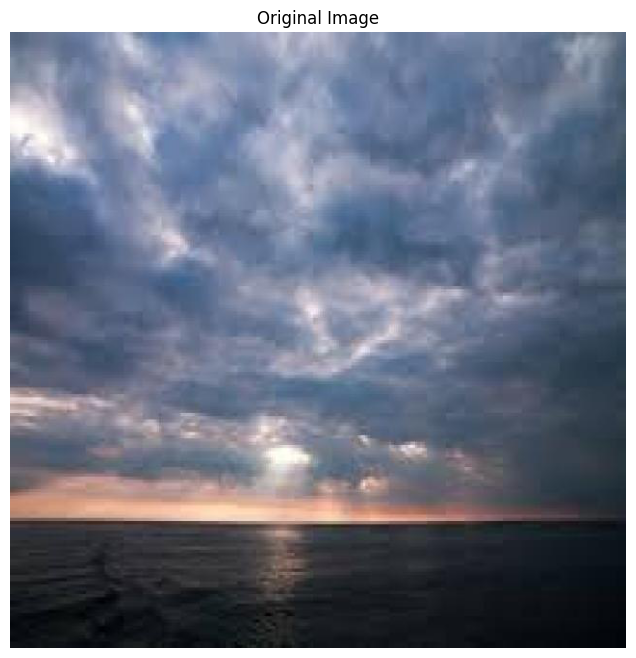

(640, 640, 3)


In [57]:
# Measure start time
start_time = time.time()

# Open Image
image = Image.open('/content/drive/MyDrive/cloudy42_jpg.rf.337fbb10a5ece1995fbe33d47ef01635.jpg')
image_1 = np.array(image)
# Display the image
plt.figure(figsize=(8, 8))
plt.title("Original Image")
plt.imshow(image)
plt.axis('off')
plt.show()
print(image_1.shape)


#Calculate SVD function

In [50]:
#Calculate SVD function
def svd(matrix, full_matrices=True, compute_uv=True):
    # Compute the eigenvalues and eigenvectors of A^T * A
    eigenvalues, eigenvectors = np.linalg.eig(matrix.T @ matrix)

    # Sort the eigenvalues in descending order
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    # Compute the singular values and singular vectors
    singular_values = np.sqrt(np.abs(eigenvalues))

    # Compute the matrices U and V
    if full_matrices:
        U = matrix @ eigenvectors / singular_values
        V = eigenvectors
    else:
        num_singular_values = min(matrix.shape)
        U = matrix @ eigenvectors[:, :num_singular_values] / singular_values[:num_singular_values]
        V = eigenvectors[:, :num_singular_values]

    if compute_uv:
        return U, singular_values, V.T
    else:
        return singular_values

    return result


#Compress function for single channel

In [51]:
#Compress function for single channel
def svd_compressor(image, order):
    """Returns the compressed image channel at the specified order"""

    # Create an array filled with zeros having the shape of the image
    compressed = np.zeros(image.shape)

    # Get the U, S and V terms (S = SIGMA)
    U, S, V = svd(image)

    # Loop over U columns (Ui), S diagonal terms (Si) and V rows (Vi) until the chosen order
    for i in range(order):
        Ui = U[:, i].reshape(-1, 1)
        Vi = V[i, :].reshape(1, -1)
        Si = S[i]
        compressed += (Ui * Si * Vi)

    return compressed

#Compress RGB Image

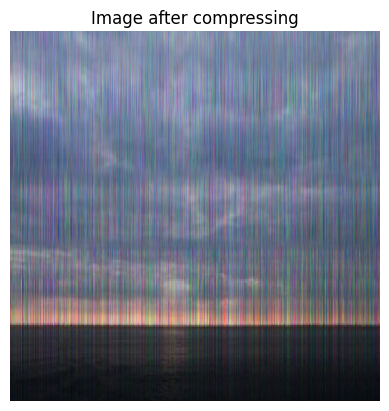

(640, 640, 3)
Compression time: 899.991024017334 seconds


In [72]:
##COMPRESSION RGB IMAGE

# Separation of the image channels
red_image = np.array(image)[:, :, 0]
green_image = np.array(image)[:, :, 1]
blue_image = np.array(image)[:, :, 2]

# Compression of each channel
order = 200
red_comp = svd_compressor(red_image, order)
green_comp = svd_compressor(green_image, order)
blue_comp = svd_compressor(blue_image, order)

# Recombinasion of the colored image
color_comp = np.zeros((np.array(image).shape[0], np.array(image).shape[1], 3))
color_comp[:, :, 0] = red_comp
color_comp[:, :, 1] = green_comp
color_comp[:, :, 2] = blue_comp
color_comp = np.around(color_comp).astype(int)

# Display of the 3 separated channels
plt.imshow(color_comp)
plt.title("Image after compressing")
plt.axis('off')
plt.show()
print(color_comp.shape)

# Measure end time
end_time = time.time()

# Calculate the time taken for compression
compression_time = end_time - start_time
print("Compression time:", compression_time, "seconds")

# Calculate RMSE and SNR

In [77]:
mse = np.mean((image_1 - color_comp)**2)
signal_power = np.max(image_1) ** 2

rmse = np.sqrt(mse)
snr = 10 * math.log10(signal_power / mse)

#print(rmse)
print('RMSE at order = {} is {:.2f}'.format(order, rmse))
print('SNR at order = {} is {:.2f}'.format(order, snr))

RMSE at order = 200 is 25.16
SNR at order = 200 is 20.12


#Calculate compression ratio

In [53]:
#Calculate compression ratio
original_size = 640*640*3
compressed_size = order * (1 + 640 + 640) * 3

compression_ratio = compressed_size * 1.0 / original_size
print('Ratio compressed size / original size:')
print(compression_ratio)

print('Compressed image size is ' + str(round(compression_ratio * 100, 2)) + '% of the original image ')


Ratio compressed size / original size:
1.99843505859375
Compressed image size is 199.84% of the original image 


#Compression image at different orders and calculate RMSE and SNR of each order

100%|██████████| 10/10 [00:27<00:00,  2.73s/it]


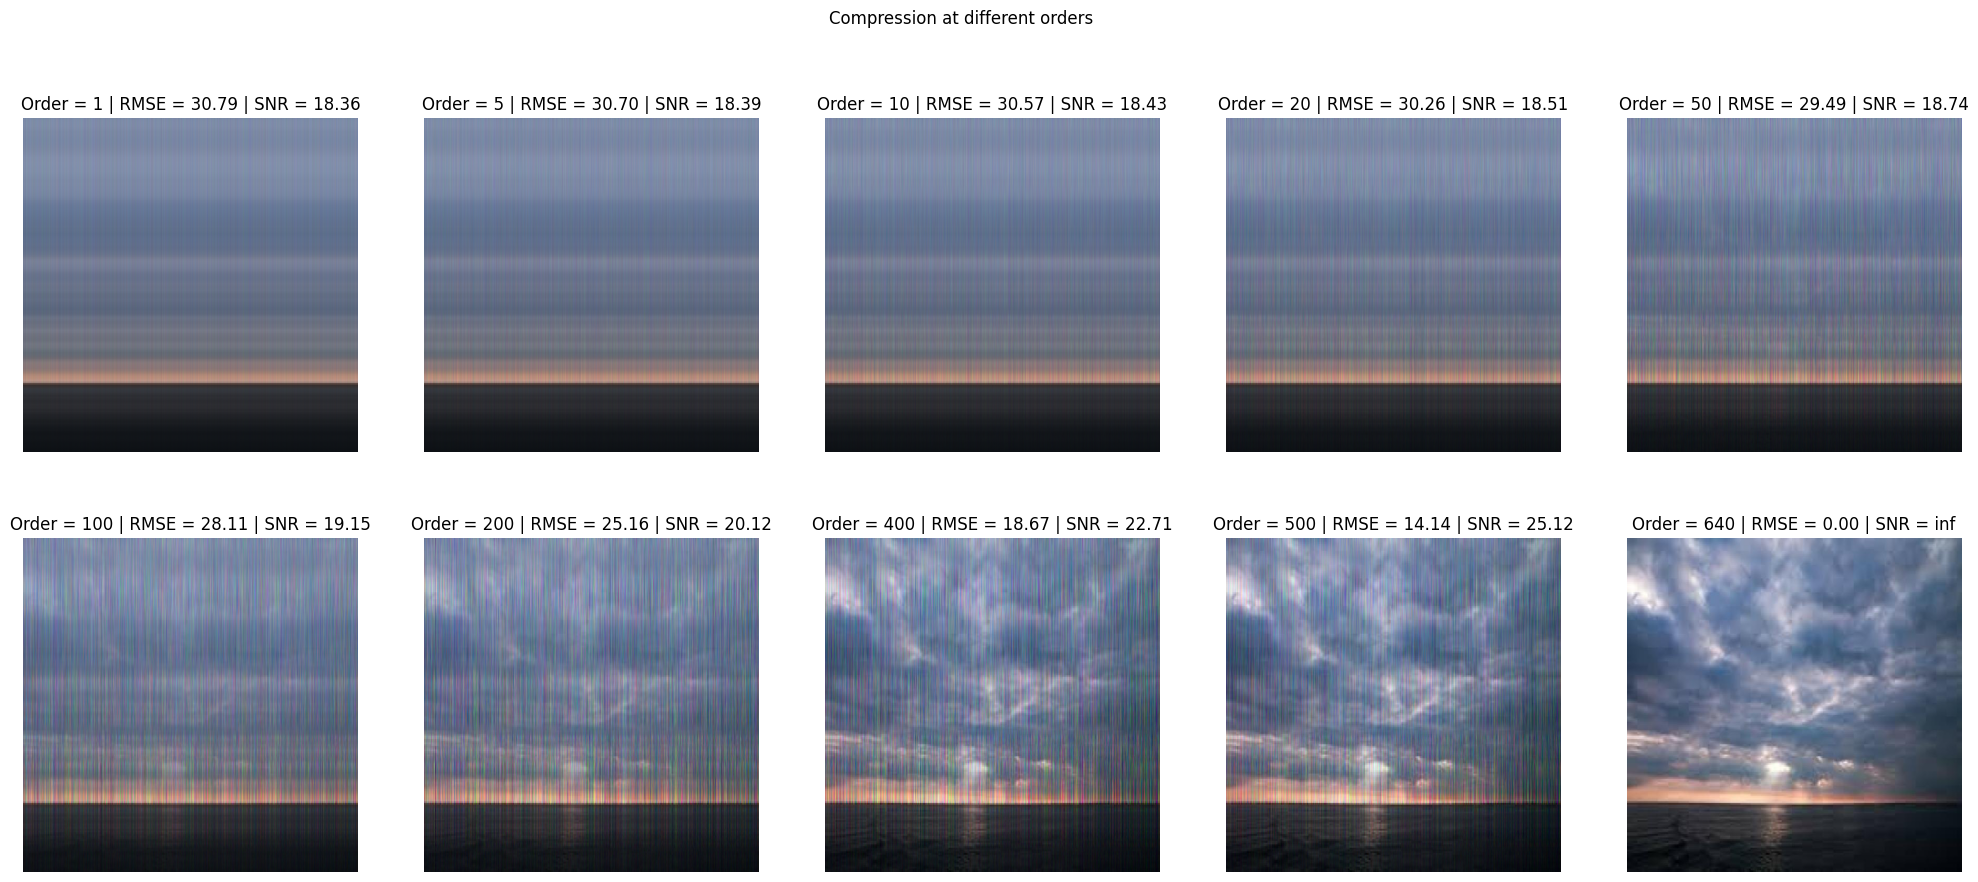

In [78]:
plt.figure(figsize=(25, 10))

orders = [1, 5, 10, 20, 50, 100, 200, 400, 500, 640]
rmse = []
snr = []
for i in tqdm(range(len(orders))):

    # Use the compressor function
    order = orders[i]
    red_comp = svd_compressor(red_image, order)
    green_comp = svd_compressor(green_image, order)
    blue_comp = svd_compressor(blue_image, order)

    # Combine images
    color_comp = np.zeros((np.array(image).shape[0], np.array(image).shape[1], 3))
    color_comp[:, :, 0] = red_comp
    color_comp[:, :, 1] = green_comp
    color_comp[:, :, 2] = blue_comp
    color_comp = np.around(color_comp).astype(int)
    # Calculate RMSE
    rmse.append(np.sqrt(np.mean((image_1 - color_comp)**2)))
    # Calculate SNR
    snr.append(10 * math.log10((np.max(image_1) ** 2) / (np.mean((image_1 - color_comp)**2))))

    # Display the compressed colored image in the subplot
    plt.subplot(2, 5, i + 1)
    plt.title("Order = {} | RMSE = {:.2f} | SNR = {:.2f}".format(order, rmse[i],snr[i] ))
    plt.axis('off')
    plt.imshow(color_comp)

plt.suptitle('Compression at different orders')
plt.show()